# ResNet50

In [23]:
import torch
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn as nn
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
!pip install torcheval
from torcheval.metrics.functional import multiclass_confusion_matrix
from torcheval.metrics import MulticlassPrecision
from torcheval.metrics import MulticlassRecall
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [24]:
device = "cpu"

if torch.cuda.is_available():
    print("cuda")
    device = "cuda"

cuda


In [25]:
model = resnet50()
model.conv1 = nn.Conv2d(1, 64, 7, 2, 3, bias=False)
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=2048, out_features=10, bias=True)
  )
model.to(device)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [26]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.003, weight_decay=1e-5)

In [27]:
criterion = nn.CrossEntropyLoss()

In [28]:
scheduler = StepLR(optimizer, step_size=7, gamma=0.2)

In [29]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

print(training_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()


In [30]:
subsample_train_indices = torch.randperm(len(training_data))[:1000]
subsample_test_indices = torch.randperm(len(test_data))[:800]

train_dataloader = DataLoader(training_data, batch_size=32, sampler=SubsetRandomSampler(subsample_train_indices))
test_dataloader = DataLoader(test_data, batch_size=32, sampler=SubsetRandomSampler(subsample_test_indices))

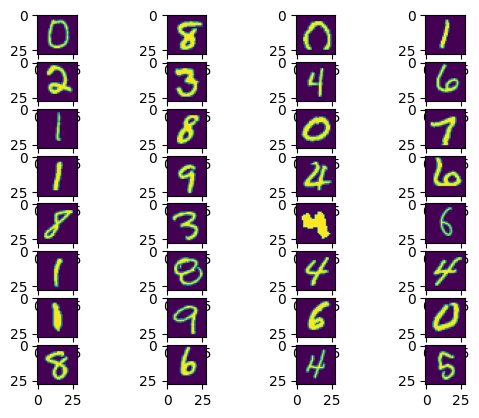

In [31]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(8, 4)
axes = axes.flatten()

batch, labels = next(iter(train_dataloader))

for i in range(32):
    image = batch[i].numpy()[0]
    axes[i].imshow(image)
plt.show()

In [32]:
preprocessing = ResNet50_Weights.DEFAULT

@torch.no_grad()
def get_accuracy(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc
def get_recall(input, target, num_classes):
  metric = MulticlassRecall(average=None, num_classes=num_classes)
  metric.update(input, target)
  return metric.compute().tolist()

def get_precision(input, target, num_classes):
  metric = MulticlassPrecision(average=None, num_classes=num_classes)
  metric.update(input, target)
  return metric.compute().tolist()

def get_precision_and_recall_pytorch(input, target, num_classes):
  return get_precision(input, target, num_classes), get_recall(input, target, num_classes)

@torch.no_grad()
def get_precision_and_recall(input, target, num_classes):
  recall=torch.zeros(num_classes, device=device)
  precision=torch.zeros(num_classes, device=device)

  false_negatives=torch.zeros(num_classes, device=device)
  false_positives=torch.zeros(num_classes, device=device)
  true_positives=torch.zeros(num_classes, device=device)

  confusion_matrix=multiclass_confusion_matrix(input, target, num_classes)

  for i in range(num_classes):
    for j in range(num_classes):
      if i==j:
        true_positives[i]=confusion_matrix[i][i]
      else:
        false_negatives[i]+=confusion_matrix[i][j]
        false_positives[j]+=confusion_matrix[i][j]
  for i in range(num_classes):
    if true_positives[i]+false_negatives[i]!=0:
      precision[i]=(true_positives[i]/(true_positives[i]+false_negatives[i])).tolist()
    if true_positives[i]+false_positives[i]!=0:
       recall[i]=(true_positives[i]/(true_positives[i]+false_positives[i])).tolist()
  return precision, recall


In [33]:
num_epochs = 30
train_loss_list = []
val_loss_list = []
accuracy_list = []
precision_list = []
recall_list = []
all_labels = []
all_predictions = []

for epoch in range(num_epochs):
    train_loss = 0
    for i, (images, labels) in enumerate(train_dataloader):

        model.train()
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(images)

        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    scheduler.step()

    model.eval()

    with torch.no_grad():
        val_loss, accuracy = 0, 0
        precision, recall = 0, 0
        for j, (images, labels) in enumerate(test_dataloader):
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            val_loss += criterion(output, labels)

            predictions = output.argmax(1)
            accuracy += get_accuracy(labels, predictions)
            batch_precision, batch_recall = get_precision_and_recall(predictions, labels, 10)
            precision += torch.tensor(batch_precision).mean()
            recall += torch.tensor(batch_recall).mean()

            if epoch == num_epochs - 1:
                all_labels.extend(labels.cpu())
                all_predictions.extend(predictions.cpu())
        train_loss /= len(train_dataloader)
        train_loss_list.append(train_loss)

        val_loss /= len(test_dataloader)
        val_loss_list.append(val_loss.cpu())

        accuracy /= len(test_dataloader)
        accuracy_list.append(accuracy)

        precision /= len(test_dataloader)
        precision_list.append(precision.cpu())

        recall /= len(test_dataloader)
        recall_list.append(recall.cpu())
        print(f'Epoch {epoch}. Train loss {train_loss}. Validation loss {val_loss}. Accuracy {accuracy} Precision {precision}. Recall {recall}')

<ipython-input-33-af66845c8790>:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  precision += torch.tensor(batch_precision).mean()
<ipython-input-33-af66845c8790>:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recall += torch.tensor(batch_recall).mean()


Epoch 0. Train loss 2.5113637689501047. Validation loss 4.720942974090576. Accuracy 18.0 Precision 0.17312383651733398. Recall 0.13641241192817688
Epoch 1. Train loss 1.107274467125535. Validation loss 0.8403850197792053. Accuracy 70.375 Precision 0.6624523997306824. Recall 0.6791131496429443
Epoch 2. Train loss 0.6729092784225941. Validation loss 0.4071017801761627. Accuracy 88.0 Precision 0.8554729223251343. Recall 0.8526841402053833
Epoch 3. Train loss 0.43671625549905. Validation loss 0.7791839241981506. Accuracy 81.375 Precision 0.7765269875526428. Recall 0.8045008182525635
Epoch 4. Train loss 0.596178283682093. Validation loss 0.9600858092308044. Accuracy 80.625 Precision 0.7827096581459045. Recall 0.7974365949630737
Epoch 5. Train loss 1.6171006381046027. Validation loss 0.9436351656913757. Accuracy 68.625 Precision 0.6748031973838806. Recall 0.7002184391021729
Epoch 6. Train loss 0.6261691465042531. Validation loss 0.2844200134277344. Accuracy 91.125 Precision 0.896717488765716

In [ ]:
sum(x.numel() for x in model.parameters())

23522250

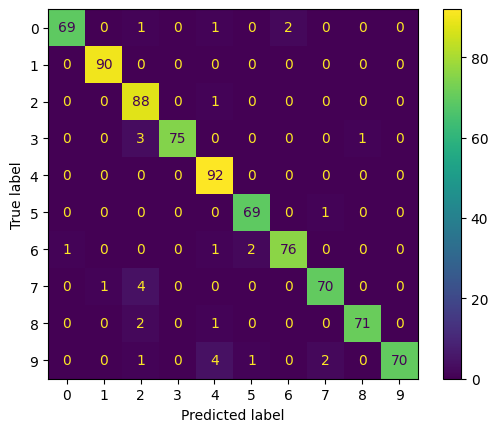

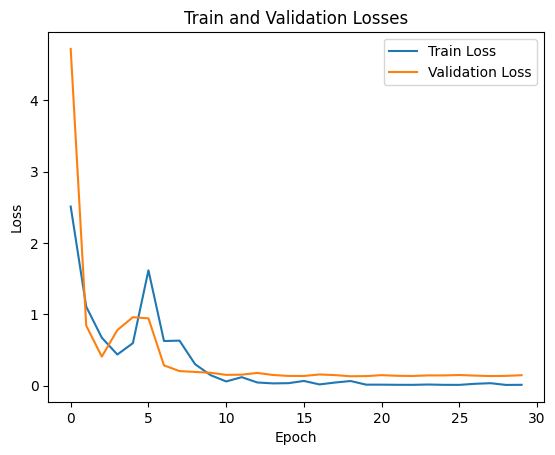

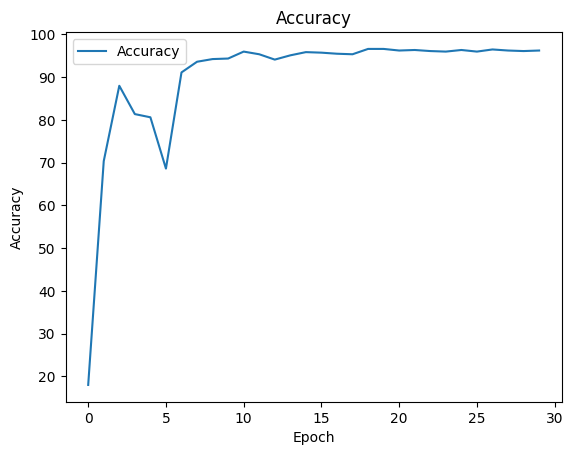

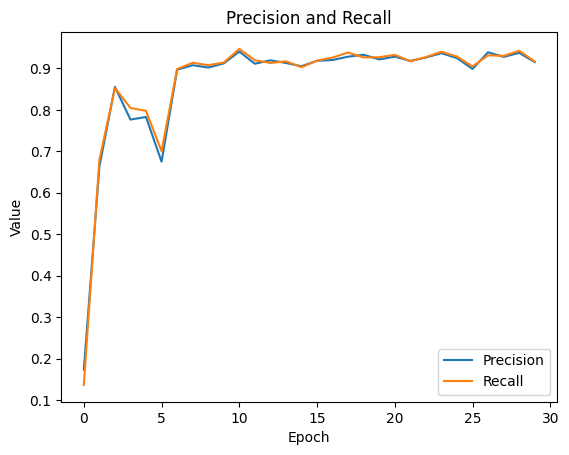

In [38]:
classes=[i for i in range(10)]
cm = confusion_matrix(all_labels, all_predictions, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=classes)
disp.plot()
plt.show()

plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Losses')
plt.legend()
plt.show()

plt.plot(accuracy_list, label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

plt.plot(precision_list, label='Precision')
plt.plot(recall_list, label='Recall')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Precision and Recall')
plt.legend()
plt.show()